In [1]:
from mssa.mssa import mSSA
import pandas as pd 
import matplotlib.pyplot as plt 
import io
import numpy as np 
import torch 
import copy 
from sklearn.metrics import r2_score
import os 

In [2]:
file = "LD2011_2014_clean.txt"
isExist = os.path.exists(file)
if not isExist:
    !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip
    !unzip LD2011_2014.txt.zip
    # change commas to dots
    !sed 's/,/./g' LD2011_2014.txt > LD2011_2014_clean.txt
else: 
    print(f"Files are ready")

Files are ready


Let's now load and preprocess the data. Specifically we will:

1- Pick the first 20 houses `MT-001`to `MT-020`


2- Remove the data before 2011, since most of its readings are zeros

3- Aggregate the data into hourly readings by avergaing the 15-minutes readings.

In [3]:
"""Preprocess data"""
data = pd.read_csv('LD2011_2014_clean.txt', delimiter = ';')
#remove data before 2012
data = data.iloc[8760*4:]
print('data loaded..')
data_2 = data.copy()
#pick the first 20 houses
data_2 = data_2.iloc[:,:]
# Aggregate
data_2['time'] =pd.to_datetime(data_2['Unnamed: 0']).dt.ceil('1h') 
data_2 = data_2.drop(['Unnamed: 0'], axis = 1)
agg_dict = {}
for col in data_2.columns[:-1]:
    agg_dict[col] ='mean'
data_3 = data_2.groupby(['time']).agg(agg_dict)
print('data aggregated..')
data_3.shape

data loaded..
data aggregated..


(26304, 370)

In [4]:
data_3.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
time,,,,,,,,,,,,,,,,,,,,,
2012-01-01 01:00:00,4.124365,22.759602,77.324066,138.211382,72.256098,348.214286,8.620690,279.461279,72.989510,87.903226,...,120.628123,25975.0,1510.548523,1659.090909,15.645372,12.873025,524.143986,60.934891,713.526393,0.0
2012-01-01 02:00:00,4.758883,23.115220,77.324066,137.195122,70.121951,339.285714,6.924816,276.094276,67.307692,82.258065,...,112.776588,23875.0,1097.046414,1653.409091,15.971317,10.532475,550.043898,61.352254,705.828446,0.0
2012-01-01 03:00:00,4.124365,22.937411,77.324066,136.686992,66.463415,286.458333,6.642171,239.898990,63.811189,72.043011,...,102.605282,24150.0,1069.620253,1642.045455,15.971317,9.654769,499.122037,50.918197,689.149560,0.0
2012-01-01 04:00:00,4.758883,22.048364,77.324066,102.134146,50.304878,191.964286,4.804975,200.336700,41.520979,46.236559,...,64.953605,23350.0,1042.194093,1579.545455,18.252934,9.654769,330.114135,47.161937,681.085044,0.0
2012-01-01 05:00:00,4.441624,21.870555,77.324066,81.808943,45.121951,155.505952,3.533070,180.134680,45.891608,42.473118,...,73.875803,22575.0,1032.700422,1568.181818,15.645372,8.777063,328.577700,47.579299,685.300587,0.0


In [5]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
Std_normalization = 1
if Std_normalization:
    scaler = StandardScaler()
    temp = scaler.fit_transform(data_3)
    norm_means = scaler.mean_
    norm_std = scaler.scale_
else:
    scaler = MinMaxScaler()
    temp = scaler.fit_transform(data_3)
global data_4
data_4 = pd.DataFrame(temp, index=data_3.index, columns = data_3.columns)

In [6]:
data_4.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
time,,,,,,,,,,,,,,,,,,,,,
2012-01-01 01:00:00,-0.193637,-0.767048,5.979015,0.750556,1.297119,2.562526,0.380006,0.420689,0.936652,1.237010,...,-0.925467,-0.660711,-0.611351,-0.924599,-1.182866,0.055241,-0.298429,-0.970811,-0.867907,-1.312616
2012-01-01 02:00:00,-0.088516,-0.711666,5.979015,0.723940,1.174705,2.419487,0.131533,0.362440,0.666522,1.016322,...,-0.968145,-0.718147,-0.862776,-0.926923,-1.177477,-0.195217,-0.111780,-0.964607,-0.923605,-1.312616
2012-01-01 03:00:00,-0.193637,-0.739357,5.979015,0.710631,0.964851,1.573172,0.090121,-0.263732,0.500288,0.616982,...,-1.023433,-0.710625,-0.879452,-0.931572,-1.177477,-0.289139,-0.478750,-1.119708,-1.044284,-1.312616
2012-01-01 04:00:00,-0.088516,-0.877811,5.979015,-0.194342,0.037999,0.059340,-0.179057,-0.948152,-0.559453,-0.391876,...,-1.228097,-0.732505,-0.896128,-0.957141,-1.139759,-0.289139,-1.696712,-1.175544,-1.102634,-1.312616
2012-01-01 05:00:00,-0.141076,-0.905502,5.979015,-0.726679,-0.259294,-0.524736,-0.365412,-1.297643,-0.351661,-0.539002,...,-1.179598,-0.753702,-0.901901,-0.961790,-1.182866,-0.383061,-1.707784,-1.169340,-1.072133,-1.312616


In [7]:
data_4.shape

(26304, 370)

Now each column of the dataframe `data` contains hourly reading starting from `2012-01-01 01:00` until `2015-01-01 01:00`. In this experiment, as mentioned before, we will split the observations into a training and testing sets. Specifically, the training set will start at  `2012-01-01 01:00` until `2014-12-18 00:00`. and the test set will have the rest of the observations.




Splitting the data into training and testing sets:

In [8]:
global n_clients; global data_train; global data_test
def set_train_test(n_clients=20):
    data_train = data_4.iloc[:25968,:n_clients] #25600; 25968; 26082
    data_test = data_4.iloc[25968:,:n_clients]
    return data_train, data_test

In [9]:
data_train, data_test = set_train_test(n_clients=370)
data_train.shape

(25968, 370)

Transform rawdata [T,N] intao Page matrix [L,Mts*N].

* L = window size
* Mts = number of column of each ts's Page matrix = [T/L]
* N = number of ts (clients)

We select the range for training as: (T mod L)+1, . . . , T

_Note that more details can be found at footnote Page 4 [Agarwal2022]. Here we use one range instead of two ranges for prediction. [He2023]_

Explanation:

N is the number of houses

L is the window size

M is the total number of column w.r.t window size L

M_ts is number of column for each house = M // N

In [10]:
def get_flattened_obs(data_train, L=80):
    df = data_train
    N = df.shape[1]
    col_to_row_ratio = 4

#     L = int(np.sqrt(df.size / (col_to_row_ratio))) # algo [Agarwal2022] to generate L, here we fix it as hyperparam
#     L = int(np.sqrt(df.shape[0] / (col_to_row_ratio))) # my N

    T = df.shape[0]

    M = int(df.size / L)
    if M%N != 0:
        M -= M%N
    M_ts = M // N
    # inc_obs = np.array(df.iloc[:M_ts*L,:]) # first range, we use second range for traning
    inc_obs = np.array(df.iloc[T%L:,:]) # second range, note its not T%L+1 due to python index
    normalize = False
    from sklearn.preprocessing import StandardScaler
    if normalize:
        scaler = StandardScaler()
        inc_obs = scaler.fit_transform(inc_obs)
        norm_means = scaler.mean_
        norm_std = scaler.scale_

    flattened_obs = inc_obs.reshape([L,M], order = 'F') # 按照列顺序
    # flattened_obs = flattened_obs[:,np.arange(M_ts*self.no_ts).reshape([self.no_ts,M_ts]).flatten('F')] # 这里导致第二列是ts2，stacked page是不同ts交错组成
    return flattened_obs, M_ts

In [11]:
global N; global M_ts; global L;
N = data_train.shape[1]
L = 80

In [12]:
flattened_obs, M_ts = get_flattened_obs(data_train, L=L)

In [13]:
flattened_obs.shape

(80, 119880)

In [14]:
data_train.shape[1], data_train.size

(370, 9608160)

Standalone SSA

In [15]:
# stand-alone ssa
global window;
window = M_ts
lst_U_sd = []
for i in range(data_train.shape[1]):
    data = flattened_obs[:,i*window:(i+1)*window]
    U,S,_ = np.linalg.svd(data)
    U = U[:,:N]
    lst_U_sd.append(U)

In [16]:
# just for verification of estimating sigma
i=0
proj_sd = lst_U_sd[i].T.dot(flattened_obs[:,i*window:(i+1)*window]) # we take one client for verification
S2_sd_est = proj_sd.dot(proj_sd.T)
S2_sd = np.diag(proj_sd.dot(proj_sd.T))
S_sd = np.sqrt(S2_sd)
# S_sd.argsort()[::-1]


## Fit mSSA

Now, using **mSSA**, we will be able to forecast and impute the data at past and future timesamps! To do that, we must first fit the model.

In [17]:
model = mSSA(rank = 20, normalize = False, L=L)
# model
model.update_model(data_train)

(25968, 370)


Need to know what are the model.ts_model.models and svd_model?

In [18]:
svd_model = vars(model.ts_model.models[0])
svd_model

{'seriesToPredictKey': 't1',
 'otherSeriesKeysArray': [],
 'includePastDataOnly': True,
 'fill_in_missing': False,
 'N': 80,
 'M': 119880,
 'start': 0,
 'TimesUpdated': 0,
 'TimesReconstructed': 0,
 'kSingularValues': 20,
 'svdMethod': 'numpy',
 'norm_mean': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

Read the representation matrix form FedSSA

In [19]:
file = "../SSA/Grassmann_ADMM_Elec20_N20_L80_d80_rhoauto_imputation.npy"
Uk_admm = np.load(file)
lst_U = []

"""Load 20 Uk for 20 users"""
for i in range(20):
    lst_U.append(Uk_admm)
lst_U[0].shape

(80, 80)

Verify that $U^TU = I$

In [20]:
np.allclose(lst_U[0].T.dot(lst_U[0])-np.eye(lst_U[0].shape[1]),np.zeros(lst_U[0].shape[1]))

True

In [21]:
svd_model["Uk"].shape

(80, 20)

In [22]:
def re_error(u, X):
    Xhat = u.dot(u.T.dot(X))
    re_error = np.linalg.norm(X-Xhat)
    return re_error

print(re_error(svd_model['Uk'], flattened_obs))
print(re_error(lst_U[0], flattened_obs))

584.4997670253099
2.7991905531861957e-12


Print imputation score of mSSA, most clients work well, while two of them have very large loss.

In [23]:
pd.DataFrame(svd_model['imputation_model_score']).describe()

,0
count,3.700000e+02
mean,-6.747968e+24
std,9.923307e+25
min,-1.833370e+27
25%,9.281804e-01
50%,9.466738e-01
75%,9.576847e-01
max,9.957414e-01


In [24]:
imputation_model_score_admm = []
P_admm = flattened_obs
P_admm_hat = []
y_admm = []
y_true = P_admm[-1,:]
P_tilde_admm_hat = []

lst_U = []
for i in range(N):
    proj_admm_i = Uk_admm.T.dot(P_admm[:,i*window:(i+1)*window])
    S2_admm_i_est = proj_admm_i.dot(proj_admm_i.T)
    S2_admm_i = np.diag(S2_admm_i_est)
    S_admm_i = np.sqrt(S2_admm_i)
    Uk_admm_i = Uk_admm[:,S_admm_i.argsort()[::-1][:74]] # sort components based on S_admm, select the first 74 components
    lst_U.append(Uk_admm_i)
for i in range(N):
    P_i_admm = P_admm[:,int(i*window):int((i+1)*window)]
    P_i_admm_hat = lst_U[i].dot(lst_U[i].T.dot(P_i_admm)); P_admm_hat.append(P_i_admm_hat)
    y_i_admm = P_i_admm_hat[-1,:]; y_admm.append(y_i_admm)
    y_i_true = P_i_admm[-1,:]
    P_i_tilde_admm_hat = P_i_admm_hat[:-1,:]; P_tilde_admm_hat.append(P_i_tilde_admm_hat)
    imputation_model_score_admm.append(r2_score(P_i_admm.flatten('F'),P_i_admm_hat.flatten('F'))) # verified same as imputation_model_score)
imputation_model_score_admm = np.array(imputation_model_score_admm)
P_admm_hat = np.hstack(P_admm_hat)
y_admm = np.hstack(y_admm)
P_tilde_admm_hat = np.hstack(P_tilde_admm_hat)

pd.DataFrame(imputation_model_score_admm).describe()

,0
count,370.000000
mean,0.989966
std,0.005803
min,0.964501
25%,0.986301
50%,0.991558
75%,0.993632
max,0.999692


In [25]:
print(re_error(svd_model['Uk'], flattened_obs))
print(re_error(lst_U[i], flattened_obs))

584.4997670253099
440.8633002053766


In [26]:
# just for debug 
proj_admm = Uk_admm.T.dot(P_admm)
S2_admm = np.diag(proj_admm.dot(proj_admm.T))
S_admm = np.sqrt(S2_admm)
S_admm.argsort()[::-1]

i=0
proj_admm0 = Uk_admm.T.dot(P_admm[:,i*window:(i+1)*window])
S2_admm0_est = proj_admm0.dot(proj_admm0.T)
S2_admm0 = np.diag(proj_admm0.dot(proj_admm0.T))
S_admm0 = np.sqrt(S2_admm0)
S_admm0.argsort()[::-1]

array([ 0, 39, 70,  5, 78, 18, 14, 27, 36, 43,  1, 64, 57, 76, 48, 16, 24,
        2, 44, 56, 35, 79, 49, 75, 29, 53, 28, 15, 54, 51, 23, 21, 12, 31,
       67, 46, 71, 10, 59, 52, 20, 34, 50, 77, 42, 38, 65, 55, 68, 45, 13,
       63,  9, 19, 41, 72, 62, 37, 17,  8,  3, 25, 66, 33, 74, 22, 32,  7,
       47, 30, 60,  4, 58, 61, 69, 11,  6, 73, 26, 40])

In [27]:
S_admm0[S_admm0.argsort()[::-1][:20]]

array([135.7884518 ,  13.54994707,  13.21572174,  13.15550154,
        12.8001035 ,  12.47367134,  12.4510079 ,  12.26980777,
        12.24707621,  12.13633473,  11.95993163,  11.90325161,
        11.55362083,  11.17534673,  11.16119089,  11.03630791,
        10.97353501,  10.96749186,  10.86496429,  10.85876178])

In [28]:
S_sd[:20]

array([136.38259942,  34.98000513,  27.26903224,  23.47157816,
        20.92209254,  19.42296134,  16.85318588,  15.98092914,
        15.16436267,  14.35193174,  13.50550732,  12.9189264 ,
        12.29680772,  12.04758896,  11.68130807,  11.42179687,
        10.90270284,  10.81349951,  10.43685157,   9.92937809])

In [29]:
imputation_model_score_sd = []
P_sd = flattened_obs
P_sd_hat = []
y_sd = []
y_true = P_sd[-1,:]
P_tilde_sd_hat = []
for i in range(370):
    P_i_sd = P_sd[:,int(i*window):int((i+1)*window)]
    P_i_sd_hat = lst_U_sd[i].dot(lst_U_sd[i].T.dot(P_i_sd)); P_sd_hat.append(P_i_sd_hat)
    y_i_sd = P_i_sd_hat[-1,:]; y_sd.append(y_i_sd)
    y_i_true = P_i_sd[-1,:]
    P_i_tilde_sd_hat = P_i_sd_hat[:-1,:]; P_tilde_sd_hat.append(P_i_tilde_sd_hat)
    imputation_model_score_sd.append(r2_score(P_i_sd.flatten('F'),P_i_sd_hat.flatten('F'))) # verified same as imputation_model_score)
imputation_model_score_sd = np.array(imputation_model_score_sd)
P_sd_hat = np.hstack(P_sd_hat)
y_sd = np.hstack(y_sd)
P_tilde_sd_hat = np.hstack(P_tilde_sd_hat)
print(imputation_model_score_sd.mean())
imputation_model_score_sd[:10]

1.0


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

### Predict future values

In [30]:
# mSSA: forecast_model_score
weights = svd_model['weights']
weights.shape

(79,)

In [31]:
def inv_S(S):
    skw = copy.deepcopy(S)
    for i in range(0, len(skw)):
        if (skw[i] > 0.0):
            skw[i] = 1.0/skw[i]
    return skw

In [32]:
Skw_inv = inv_S(svd_model['skw'])
# X = svd_model['obs_'].reshape([N,M], order='F') # (verified) This is our flattened_obs but second col is second time series
X_hat_tilde = svd_model['matrix'][:-1,:]
y = svd_model['lastRowObservations']
# verified
weights_by_U = svd_model['Ukw'] @ np.diag(Skw_inv) @ np.diag(Skw_inv) @ svd_model['Ukw'].T @ X_hat_tilde @ y
weights_by_V = svd_model['Ukw'] @ np.diag(Skw_inv) @ svd_model['Vkw'].T @ y
print(np.allclose(svd_model['weights'], weights_by_V))
print(np.allclose(svd_model['weights'], weights_by_U))


True
True


Verify that $\tilde{S}_k^{-1}=\sqrt{(\tilde{U}_k^T\tilde{X})(\tilde{X}^T \tilde{U}_k)}$

In [33]:
proj = svd_model['Ukw'].T @ X_hat_tilde
skw_by_U = np.sqrt(np.diag(proj.dot(proj.T)))
np.allclose(skw_by_U, svd_model['skw'])

True

In [34]:
svd_model['lastRowObservations']
svd_model['Ukw'] # Vkw skw
svd_model['forecast_model_score']

array([ 7.05163571e-01,  7.71531878e-01,  9.62787003e-01,  8.74369357e-01,
        7.05052278e-01,  7.61813867e-01,  8.85447548e-01,  8.64359432e-01,
        7.79118799e-01,  9.01937870e-01, -4.22524242e-01, -1.37540739e-01,
        8.68843169e-01,  8.38566855e-01,  9.13056180e-01,  8.70598440e-01,
        9.12281559e-01,  9.10207818e-01,  9.46222663e-01,  8.95028126e-01,
        8.32272836e-01,  8.57883122e-01,  8.95170046e-01,  8.35418478e-01,
        8.26911673e-01,  9.66733583e-01,  9.90583316e-01,  9.87316779e-01,
        8.84596363e-01,  8.60840342e-01,  8.60557114e-01,  8.75183985e-01,
        8.88847479e-01,  8.97671636e-01,  8.68546468e-01,  8.68442147e-01,
        8.11652388e-01,  7.84960665e-01,  7.92647087e-01,  8.07261314e-01,
        8.17575151e-01,  9.00287330e-01,  8.90930615e-01,  8.97438461e-01,
        8.48624055e-01,  0.00000000e+00,  9.61412018e-01,  9.25452302e-01,
        9.74568783e-01,  9.65552561e-01,  9.58656007e-01,  9.69624011e-01,
        9.60989560e-01,  

Obtain admm $\tilde{X}^{T^+}_{\text{admm}} = US^{-1}S^{-1}U^T\tilde{X}y$

In [35]:
# verify weights_admm using sklearn
from sklearn.linear_model import LinearRegression
reg = LinearRegression(fit_intercept=False).fit(P_tilde_admm_hat.T, y_admm)
weights_LR = reg.coef_
print(weights_LR.shape)
weights_LR[:10]

(79,)


array([ 0.06055375,  0.03043717, -0.01696876, -0.00968472,  0.00047129,
       -0.02505868, -0.15382426,  0.13943703,  0.01219771,  0.0070367 ])

In [36]:
# verify weights_admm using sklearn
from sklearn.linear_model import LinearRegression
reg = LinearRegression(fit_intercept=False).fit(P_tilde_sd_hat.T, y_sd)
weights_sd = reg.coef_
print(weights_sd.shape)
weights_sd[:10]

(79,)


array([ 0.00042177, -0.00758506,  0.0032075 , -0.02188147,  0.01117497,
       -0.01817971, -0.14854132,  0.19439216,  0.02367364,  0.01271351])

In [37]:
ypred_admm =  weights_LR @ P_tilde_admm_hat
ypred1_admm = ypred_admm[:M_ts]
ypred20_admm = ypred_admm[-M_ts:]
forecast_model_score1_admm = r2_score(y_true[:M_ts], ypred1_admm)
forecast_model_score20_admm = r2_score(y_true[-M_ts:], ypred20_admm)
forecast_model_score_admm = r2_score(y_true, ypred_admm)
print(forecast_model_score1_admm)
print(forecast_model_score20_admm)
print(forecast_model_score_admm)

0.758721722374327
0.9803728779333002
0.9082238476878649


In [38]:
ypred_sd =  weights_sd @ P_tilde_sd_hat
ypred1_sd = ypred_sd[:M_ts]
ypred20_sd = ypred_sd[-M_ts:]
forecast_model_score1_sd = r2_score(y_true[:M_ts], ypred1_sd)
forecast_model_score20_sd = r2_score(y_true[-M_ts:], ypred20_sd)
forecast_model_score_sd = r2_score(y_true, ypred_sd)
print(forecast_model_score1_sd)
print(forecast_model_score20_sd)
print(forecast_model_score_sd)

0.7224166475730223
0.9774291614327283
0.9114923375137827


In [39]:
print(svd_model['forecast_model_score'].mean())
svd_model['forecast_model_score']

-9.97180980222299e+25


array([ 7.05163571e-01,  7.71531878e-01,  9.62787003e-01,  8.74369357e-01,
        7.05052278e-01,  7.61813867e-01,  8.85447548e-01,  8.64359432e-01,
        7.79118799e-01,  9.01937870e-01, -4.22524242e-01, -1.37540739e-01,
        8.68843169e-01,  8.38566855e-01,  9.13056180e-01,  8.70598440e-01,
        9.12281559e-01,  9.10207818e-01,  9.46222663e-01,  8.95028126e-01,
        8.32272836e-01,  8.57883122e-01,  8.95170046e-01,  8.35418478e-01,
        8.26911673e-01,  9.66733583e-01,  9.90583316e-01,  9.87316779e-01,
        8.84596363e-01,  8.60840342e-01,  8.60557114e-01,  8.75183985e-01,
        8.88847479e-01,  8.97671636e-01,  8.68546468e-01,  8.68442147e-01,
        8.11652388e-01,  7.84960665e-01,  7.92647087e-01,  8.07261314e-01,
        8.17575151e-01,  9.00287330e-01,  8.90930615e-01,  8.97438461e-01,
        8.48624055e-01,  0.00000000e+00,  9.61412018e-01,  9.25452302e-01,
        9.74568783e-01,  9.65552561e-01,  9.58656007e-01,  9.69624011e-01,
        9.60989560e-01,  

## Prediction 

### Foracsting One hour ahead for the next  day

Let's  start by forecasting the first day for user `MT_020` and compare it visually with the test data.  Now we will produce the forecast for the next day using `predict` for the range `2014-12-18 01:00:00` to `2014-12-19  00:00:00` along with the 95% confidence interval.



In [40]:
model = mSSA(rank = 20, normalize = False, L=80)
# model
model.update_model(data_train)

(25968, 370)


In [41]:
model_my = mSSA(rank = 20, normalize = False, L=L)
# model
model_my.update_model(data_train)

(25968, 370)


In [42]:
model_sd = mSSA(rank = 20, normalize = False, L=L)
# model
model_sd.update_model(data_train)

(25968, 370)


In [43]:
model_my.ts_model.models[0].weights = weights_LR
model_sd.ts_model.models[0].weights = weights_sd

In [44]:
def predict_one_day(data_test, model, weights):

    #initialise prediction array
    predictions = np.zeros((len(data_test.columns),24*7))
    ub = np.zeros((len(data_test.columns),24*7))
    lb = np.zeros((len(data_test.columns),24*7))

    # specify start time
    start_time = pd.Timestamp('2014-12-18 01:00:00')

    # actual = data_test.values[:24*7,:]

    # obtain new actual by index, new test start from 2014-12-02-17:00
    actual = data_test[data_test.index>=start_time].values[:24*7,:]

    # predict for seven days
    days = 7

    for day in range(days):
        # get the final time stamp in the day
        end_time = start_time + pd.Timedelta(hours=23)
        # convert timestamps to string
        start_str = start_time.strftime('%Y-%m-%d %H:%M:%S')
        end_str = end_time.strftime('%Y-%m-%d %H:%M:%S')
        # predict for each house
        for i, column in enumerate(data_test.columns):
            # Forecast
            df_30 = model.predict(column,start_str,end_str)
            predictions[i,day*24:(day+1)*24] = df_30['Mean Predictions']
            ub[i,day*24:(day+1)*24] = df_30['Upper Bound']
            lb[i,day*24:(day+1)*24] = df_30['Lower Bound']

        # fit the model with the already predicted values 

        # df_insert = data_test.iloc[day*24:24*(day+1),:]

        # obtain new df_insert
        # df_insert = data_test[data_test.index>=start_time].iloc[day*24:24*(day+1),:]

        # model.update_model(df_insert)
    
        if weights is not None:
            model.ts_model.models[0].weights = weights

        # update start_time
        start_time = start_time + pd.Timedelta(hours=24)
    return actual, predictions

In [45]:
def test_sd(data_train, data_test, L, n_users, M_ts, dim, days, plot_all):
    flattened_obs, M_ts = get_flattened_obs(data_train, L=L)
    # stand-alone ssa
    global window;
    window = M_ts
    lst_U_sd = []
    for i in range(n_users):
        data = flattened_obs[:,i*window:(i+1)*window]
        U,_,_ = np.linalg.svd(data)
        U = U[:,:dim]
        lst_U_sd.append(U)
        
    model_sd = mSSA(rank = dim, normalize = False, L=L)
    model_sd.update_model(data_train)

    P_sd = flattened_obs
    P_sd_hat = []
    y_sd = []
    y_true = P_sd[-1,:]
    P_tilde_sd_hat = []
    imputation_model_score_sd = []
    
    for i in range(n_users):
        P_i_sd = P_sd[:,int(i*window):int((i+1)*window)]
        P_i_sd_hat = lst_U_sd[i].dot(lst_U_sd[i].T.dot(P_i_sd)); P_sd_hat.append(P_i_sd_hat)
        y_i_sd = P_i_sd_hat[-1,:]; y_sd.append(y_i_sd)
        y_i_true = P_i_sd[-1,:]
        P_i_tilde_sd_hat = P_i_sd_hat[:-1,:]; P_tilde_sd_hat.append(P_i_tilde_sd_hat)
        imputation_model_score_sd.append(r2_score(P_i_sd.flatten('F'),P_i_sd_hat.flatten('F'))) # verified same as imputation_model_score)
    imputation_model_score_sd = np.array(imputation_model_score_sd)
    P_sd_hat = np.hstack(P_sd_hat)
    y_sd = np.hstack(y_sd)
    P_tilde_sd_hat = np.hstack(P_tilde_sd_hat)
    print("imputation score:", imputation_model_score_sd.mean())

    # verify weights_admm using sklearn
    from sklearn.linear_model import LinearRegression
    reg = LinearRegression(fit_intercept=False).fit(P_tilde_sd_hat.T, y_sd)
    weights_sd = reg.coef_
    
    model_sd.ts_model.models[0].weights = weights_sd
    
    actual, predictions_sd = predict_one_day(data_test, model_sd, weights_sd)

    Y = actual[:,:]
    Y_h_sd = predictions_sd.T[:,:]
    mse_sd = np.sqrt(np.mean(np.square(Y[:7*days]-Y_h_sd[:7*days])))
    print ('Forecasting accuracy (RMSE) my:',mse_sd)
    
    if plot_all:
        npar = np.arange(0,20)
    else: npar = [1]
    for i in npar:
        plt.figure()
        plt.title('forecasting the next seven days for %s'%data_test.columns[i])
#         plt.plot(predictions[i,:24*days],label= 'mSSA',color='green')
#         plt.plot(predictions_my[i,:24*days],label= 'FedmSSA',color='orange')
        plt.plot(predictions_sd[i,:24*days],label= 'sd',color='pink')
        plt.plot(actual[:24*days,i],label = 'actual',color='blue')
        plt.legend()
    plt.show()
    
    return Y, Y_h_sd, weights_sd, lst_U_sd

In [46]:
def test_my(data_train, data_test, L, n_users, M_ts, dim, days, plot_all):

    flattened_obs, M_ts = get_flattened_obs(data_train, L=L)

    # model
    model_my = mSSA(rank = dim, normalize = False, L=L)
    # model
    model_my.update_model(data_train)

    P_admm = flattened_obs
    file_name = f"../SSA/Grassmann_ADMM_Elec20_N370_L80_d80_rhoauto_imputation.npy"
    Uk_admm = np.load(file_name)
    
    
    # Select PCs by Sigma
    lst_U = []
    for i in range(n_users):
        proj_admm_i = Uk_admm.T.dot(P_admm[:,i*M_ts:(i+1)*M_ts])
        S2_admm_i_est = proj_admm_i.dot(proj_admm_i.T)
        S2_admm_i = np.diag(S2_admm_i_est)
        S_admm_i = np.sqrt(S2_admm_i)
        Uk_admm_i = Uk_admm[:,S_admm_i.argsort()[::-1][:dim]] # 针对每一个client，取Uk的那20列，which 取决于 S_admm的大小
        lst_U.append(Uk_admm_i)
    
    # Select PCs randomly
#     select_idx = np.random.choice(np.arange(L),dim,replace=False)
#     lst_U = []
#     for i in range(n_users):
#         lst_U.append(Uk_admm[:,:dim])
#     print("Uk shape: ", lst_U[0].shape)

    imputation_model_score_admm = []
    
    P_admm_hat = []
    y_admm = []
    y_true = P_admm[-1,:]
    P_tilde_admm_hat = []
    window = M_ts
    for i in range(n_users):
        P_i_admm = P_admm[:,int(i*window):int((i+1)*window)]
        P_i_admm_hat = lst_U[i].dot(lst_U[i].T.dot(P_i_admm)); P_admm_hat.append(P_i_admm_hat)
        y_i_admm = P_i_admm_hat[-1,:]; y_admm.append(y_i_admm)
        y_i_true = P_i_admm[-1,:]
        P_i_tilde_admm_hat = P_i_admm_hat[:-1,:]; P_tilde_admm_hat.append(P_i_tilde_admm_hat)
        imputation_model_score_admm.append(r2_score(P_i_admm.flatten('F'),P_i_admm_hat.flatten('F'))) # verified same as imputation_model_score)
    imputation_model_score_admm = np.array(imputation_model_score_admm)
    P_admm_hat = np.hstack(P_admm_hat)
    y_admm = np.hstack(y_admm)
    P_tilde_admm_hat = np.hstack(P_tilde_admm_hat)

    print("imputation score", imputation_model_score_admm.mean())

    # verify weights_admm using sklearn
    from sklearn.linear_model import LinearRegression
    reg = LinearRegression(fit_intercept=False).fit(P_tilde_admm_hat.T, y_admm)
    weights_LR = reg.coef_
    
    model_my.ts_model.models[0].weights = weights_LR
    
    actual, predictions_my = predict_one_day(data_test, model_my, weights_LR)

    Y = actual[:,:]
    Y_h_my = predictions_my.T[:,:]
    mse_my = np.sqrt(np.mean(np.square(Y[:7*days]-Y_h_my[:7*days])))
    print ('Forecasting accuracy (RMSE) my:',mse_my)
    
    if plot_all:
        npar = np.arange(0,25)
    else: npar = [1]
    for i in npar:
        plt.figure()
        plt.title('forecasting the next seven days for %s'%data_test.columns[i])
#         plt.plot(predictions[i,:24*7],label= 'mSSA',color='green')
        plt.plot(predictions_my[i,:24*days],label= 'FedmSSA',color='orange')
    #     plt.plot(predictions_sd[i,:24*7],label= 'sd',color='pink')
    #     plt.fill_between(np.arange(24*7), lb[i,:24*7], ub[i,:24*7], alpha = 0.1)
        plt.plot(actual[:24*days,i],label = 'actual',color='blue')
        plt.legend()
    plt.show()
    
    return Y, Y_h_my, weights_LR, lst_U


In [47]:
def test_mssa(data_train, data_test, rank, L, n_users, days, plot_all):
    data_train = data_train.iloc[:,:n_users]
    data_test = data_test.iloc[:,:n_users]
    model = mSSA(rank = rank, normalize = False, L=L)
    # model
    model.update_model(data_train)
    actual, predictions = predict_one_day(data_test, model, None)

    Y = actual[:,:]
    Y_h = predictions.T[:,:]
    mse = np.sqrt(np.mean(np.square(Y[:7*days]-Y_h[:7*days])))
    print ('Forecasting accuracy (RMSE):',mse)
    
    if plot_all:
        npar = np.arange(0,20)
    else: npar = [1]
    for i in npar:
        plt.figure()
        plt.title('forecasting the next seven days for %s'%data_test.columns[i])
        plt.plot(predictions[i,:24*days],label= 'mSSA',color='green')
#         plt.plot(predictions_my[i,:24*7],label= 'FedmSSA',color='orange')
    #     plt.plot(predictions_sd[i,:24*7],label= 'sd',color='pink')
    #     plt.fill_between(np.arange(24*7), lb[i,:24*7], ub[i,:24*7], alpha = 0.1)
        plt.plot(actual[:24*days,i],label = 'actual',color='blue')
        plt.legend()
    plt.show()
    
    return Y, Y_h, model.ts_model.models[0].weights

(25968, 370)
imputation score: 0.9999471664370172
Forecasting accuracy (RMSE) my: 0.294990277751111


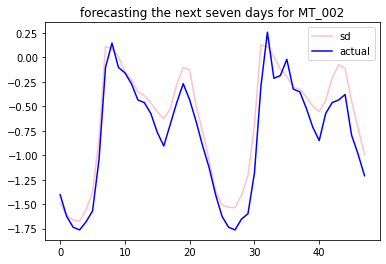

In [73]:
for dim in [1]:
    Y1, Y_sd, weights_sd, lst_U_sd = test_sd(data_train, data_test, L=80, n_users=370, M_ts=window, dim=79, days=2, plot_all=False)

(25968, 370)
Forecasting accuracy (RMSE): 0.38772855120008515


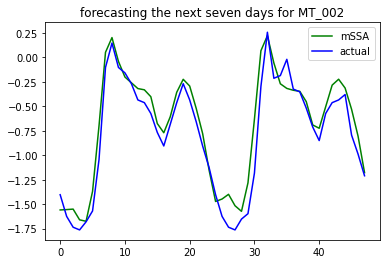

In [75]:
for rank in [15]:
    Y2, Y_mssa, weights_mssa = test_mssa(data_train, data_test, rank=20, L=80, n_users=370, days=2, plot_all=False)

(25968, 370)
imputation score 0.9986062608520337
Forecasting accuracy (RMSE) my: 0.29686218615795557


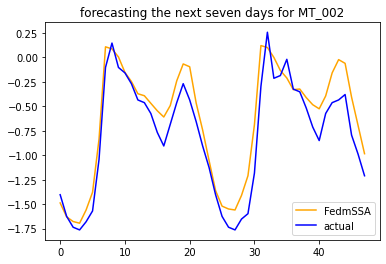

In [72]:
Y3, Y_my, weights_my, lst_U_my = test_my(data_train, data_test, L=80, n_users=370, M_ts=window, dim=79, days=2, plot_all=False)